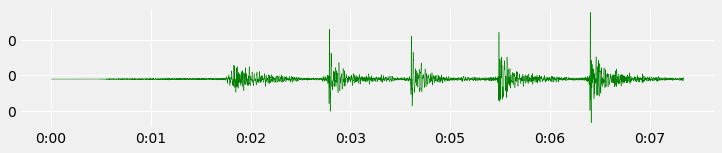

In [213]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
 

def to_sprectrogram(z):
    types = {
    1: np.int8,
    2: np.int16,
    4: np.int32
    }
    
    def format_time(x, pos=None):
        global duration, nframes, k
        progress = int(x / float(nframes) * duration * k)
        mins, secs = divmod(progress, 60)
        hours, mins = divmod(mins, 60)
        out = "%d:%02d" % (mins, secs)
        if hours > 0:
            out = "%d:" % hours
        return out
 
    def format_db(x, pos=None):
        if pos == 0:
            return ""
        global peak
        if x == 0:
            return "-inf"
 
        db = 20 * math.log10(abs(x) / float(peak))
        return int(db)
    
    wav = wave.open(z, mode = "r")
    (nchannels, sampwidth, framerate, nframes, comptype, compname) = wav.getparams()
    
    duration = nframes / framerate
    w, h = 800, 300
    k = int(nframes/w/32)
    DPI = 72
    peak = 256 ** sampwidth / 2
    
    content = wav.readframes(nframes)
    samples = np.fromstring(content, dtype=types[sampwidth])
    
    plt.figure(1, figsize=(float(w)/DPI, float(h)/DPI), dpi=DPI)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    for n in range(nchannels):
        channel = samples[n::nchannels]
        #channel = channel[0::k]
        if nchannels == 1:
            channel = channel - peak
        
        axes = plt.subplot(2, 1, n+1)
        axes.plot(channel, "g", linewidth=0.5)
        axes.yaxis.set_major_formatter(ticker.FuncFormatter(format_db))
        plt.grid(True, color="w")
        axes.xaxis.set_major_formatter(ticker.NullFormatter())
          
    axes.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
    plt.savefig("wave", dpi=DPI)
    plt.show()
    return pd.DataFrame({'Frequence' : pd.Series(channel)})  
data = to_sprectrogram("t_knocking_door_0089_time_stretch_8.wav")

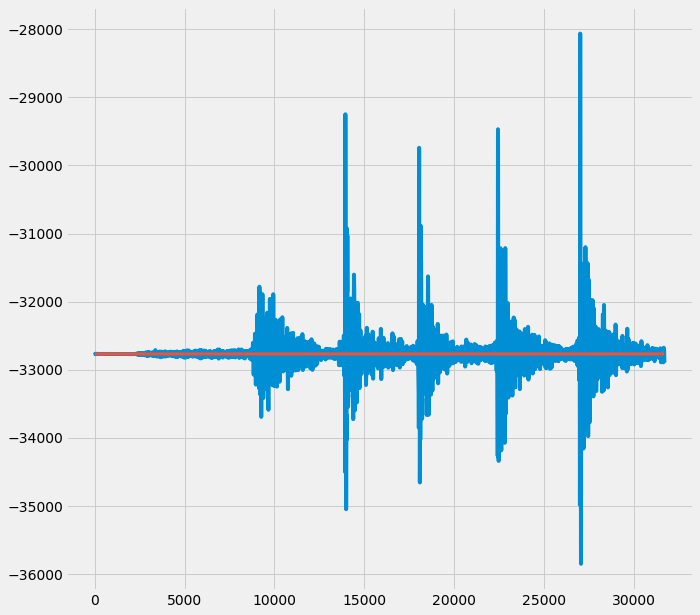

In [214]:
plt.figure(figsize=(10,10))
plt.plot(data)
y = np.polyfit(data.index, data.Frequence, deg = 1)       
plt.plot(data.index, y[0]*data.index+y[1], linewidth = 3)

In [215]:
data

,Frequence
0,-32768.0
1,-32769.0
2,-32768.0
3,-32768.0
4,-32769.0
5,-32768.0
6,-32768.0
7,-32769.0
8,-32768.0
9,-32768.0


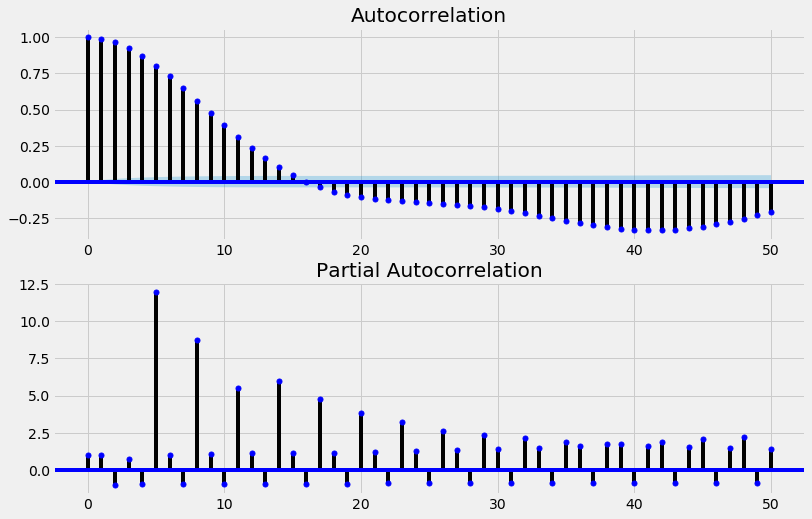

In [216]:
import statsmodels.api as sm
def Draw_autcorrelation(y, c='b'):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(y, lags=50, ax=ax1,color=c)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(y, lags=50, ax=ax2,color=c)
    plt.show()
    pass
Draw_autcorrelation(data)

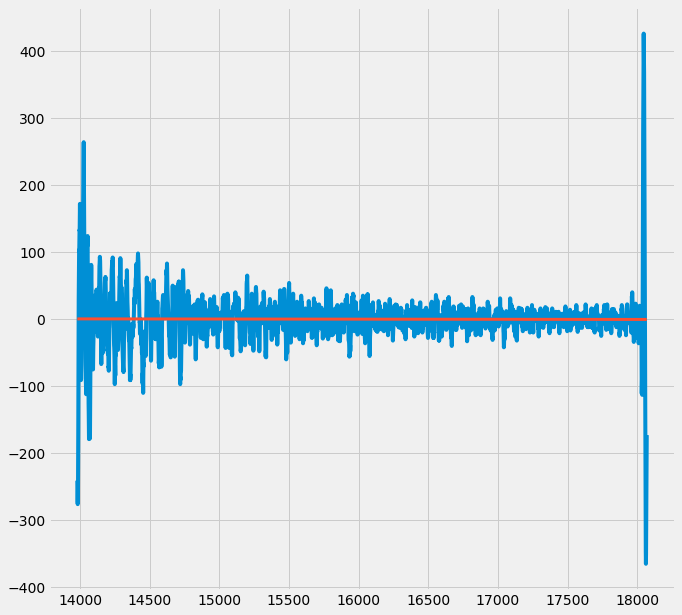

In [224]:
data_dif = pd.DataFrame({'Frequence' : data.Frequence})
data_dif.Frequence = pd.core.series.Series(data_dif.Frequence[i + 1] - 
                               data_dif.Frequence[i] for i in range(len(data_dif) - 1))
plt.figure(figsize=(10,10))
plt.plot(data_dif)
y = np.polyfit(data_dif.index, data_dif.Frequence, deg = 1)       
plt.plot(data_dif.index, y[0]*data_dif.index+y[1], linewidth = 3)

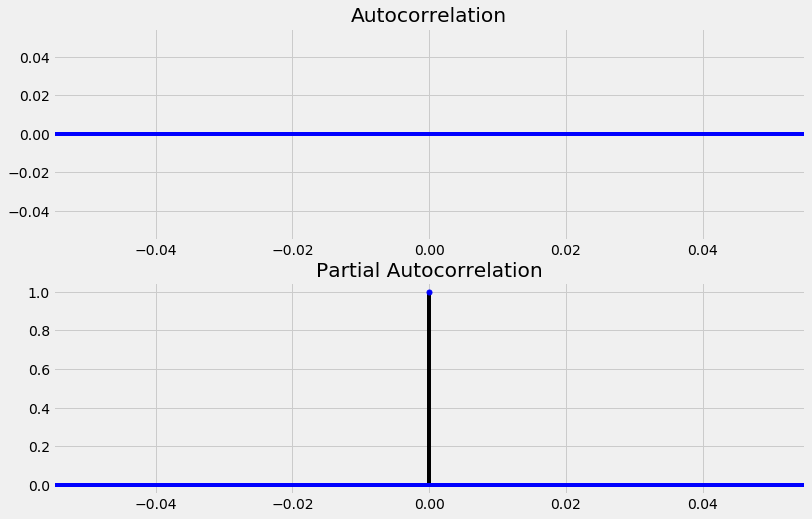

In [218]:
Draw_autcorrelation(data_dif)

In [ ]:
#     насколько я поняла, мы стремимся к тому, чтобы график autocorrelation был как можно больше приближен к 0
# для этого мы обрабатываем данные путем вычитания из значения частоты с индексом i+1 значение частоты с индексом i,
# чтобы зависимость частоты от индекса (для других случаев другие зависимости) стала стационарной, т.е. линия тренда имела
# угол наклона 0
#     если этой обработки мало, то, рассматривая график зависимости обработанной частоты от индекса, можно выделить некий период 
# (обозначим его за z), мы еще раз обрабатываем данные путем вычитания из значения частоты с индексом i+z значение частоты 
# с индексом i
#     предыдущий абзац повторяется, пока график autocorrelation не начнет нас устраивать или пока мы уже не сможем находить
# периодичность
#     опять-таки насколько я поняла, для того, чтобы не мы сами определяли периодичность, надо использовать модель SARIMA,
# но как именно это сделать я не разобралась